In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import collections
import functools
import seaborn as sns
from scipy.interpolate import interp1d

sns.set_context('poster')
sns.set_style('white')
sns.set_palette('Paired', 25)
colors = sns.color_palette('Paired', 25)

/home/teodor/.local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# No water

In [8]:
states_no_water = collections.defaultdict(dict)
nb_no_water = collections.defaultdict(dict)
t2name = {'t0': 'D', 't1': 'A', 't3': 'C', 't4': 'E', 't5': 'W'}
path = 'scan_p_1000/no_water_no_cycle/'
for f in os.listdir(path):
    if f.startswith('states_'):
        p = f.split('_')[3]
        type_id = f.split('_')[1]
        if type_id not in t2name:
            continue
        t = t2name[type_id]
        d = np.loadtxt(os.path.join(path, f))
        #d.dtype = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]
        if t not in states_no_water[p]:
            states_no_water[p][t] = []
        states_no_water[p][t].append(d)
    elif f.startswith('nb_'):
        p = f.split('_')[6]
        t = f.split('_')[4]
        nb_no_water[p][t] = np.loadtxt(os.path.join(path, f))
        #nb_no_water[p][t].dtype = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]

In [12]:
states_no_water.keys()

['0.0001', '0.001']

In [9]:
avg_states_no_water = collections.defaultdict(dict)
std_states_no_water = collections.defaultdict(dict)

max_states = {'A': 3, 'C': 3, 'E': 3, 'D': 3}
column = {'D': 3, 'A': 2, 'C': 1, 'E': 2}

for p, p_ts in states_no_water.items():
    for t, l in p_ts.items():
        max_length = min([len(k) for k in l])
        max_first_nonzero = 0
        tmp_l = []
        for ll in l:
            dll = np.diff(ll[:, column[t]])
            first_nonzero = np.nonzero(dll)[0][0]
            if first_nonzero > max_first_nonzero:
                max_first_nonzero = first_nonzero
        for ll in l:
            tmp_l.append(ll[first_nonzero:max_length])
        av = np.average(tmp_l, axis=0)
        avg_states_no_water[p][t] = av
        std_states_no_water[p][t] = np.std(tmp_l, axis=0)

In [13]:
avg_states_no_water.keys()

['0.0001', '0.001']

In [14]:
def f_1(y, t):
    s0 = y[0]
    s1 = y[1]
    s2 = y[2]
    k0 = 0.0001
    k1 = 0.0001
    k2 = 0.0001
    
    ds2dt = -k2*s2
    ds1dt = -k1*s1 + k2*s2
    ds0dt = k1*s1
    
    return np.array([ds0dt, ds1dt, ds2dt])

In [15]:
states_no_water.keys()

['0.0001', '0.001']

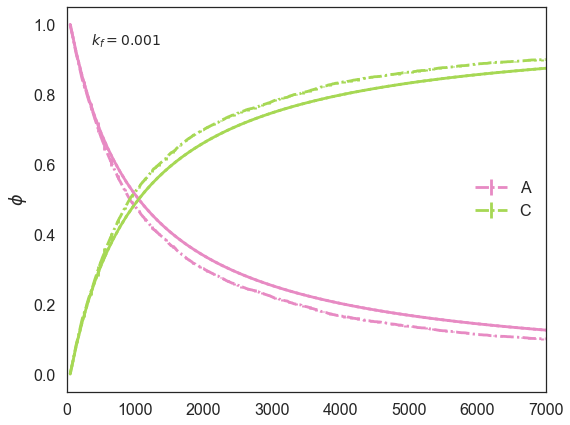

In [66]:
cr = '0.001'
tD = avg_states_no_water[cr]['D']
tA = avg_states_no_water[cr]['A']
tC = avg_states_no_water[cr]['C']
tE = avg_states_no_water[cr]['E']

def f_de(y, t, k):
    cD   = y[0]
    cEs1 = y[1]
    cEs0 = y[2]
    kcD   = k
    kcEs1 = k
    kcEs0 = k
    
    dcDdt = -kcD*cD
    dcEs1dt = kcD*cD - kcEs1*cEs1
    dcEs0dt = kcEs1*cEs1
    
    return np.array([dcDdt, dcEs1dt, dcEs0dt])

t0 = np.linspace(52, tE[:, 0][-1], 100)

y0 = np.array([1.0, 0.0, 0.0])
y = odeint(f_de, y0, t0, args=(float(cr),))

def f_ac(y, t, k):
    a = y[0]
    c = y[1]
    dadt = -k*a**2
    dcdt = k*a**2
    
    return np.array([dadt, dcdt])

t0 = np.linspace(52, tE[:, 0][-1], 100)
y_ac = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(float(cr),))
y_ac_raw = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(float(cr),))

plt.rcParams['figure.figsize'] = (8, 6)
f, (a0) = plt.subplots(1,1) #, gridspec_kw = {'height_ratios':[2, 1]})

a0.errorbar(tA[:, 0], tA[:, 2]/2000.0, std_states_no_water[cr]['A'][:, 2]/2000.0, errorevery=100, 
             linestyle='-.', label='A', color=sns.color_palette('Set2', 6)[3])
a0.errorbar(tC[:, 0], tC[:, 1]/2000.0, std_states_no_water[cr]['C'][:, 1]/2000.0, errorevery=100, 
             linestyle='-.', label='C', color=sns.color_palette('Set2', 6)[4])
a0.plot(t0, y_ac[:, 0], color=sns.color_palette('Set2', 6)[3])
a0.plot(t0, y_ac[:, 1], color=sns.color_palette('Set2', 6)[4])
a0.plot(t0, y_ac_raw[:, 0], color=sns.color_palette('Set2', 6)[3], linestyle=':')
a0.plot(t0, y_ac_raw[:, 1], color=sns.color_palette('Set2', 6)[4], linestyle=':')
a0.annotate(r'$k_f={}$'.format(cr), xy=(0.05, 0.9), xycoords='axes fraction', fontsize=14)

a0.set_ylabel(r'$\phi$')
a0.set_xlim([0, 7000])
a0.legend(loc=0)

# fA = interp1d(tA[:, 0], tA[:, 2]/2000.0)
# fC = interp1d(tC[:, 0], tC[:, 1]/2000.0)
# a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac[:, 0], 2)), color='b')
# a1.plot(t0, np.sqrt(np.power(fC(t0) - y_ac[:, 1], 2)), color='b')
# a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac_raw[:, 0], 2)), color='r')
# a1.plot(t0, np.sqrt(np.power(fC(t0) - y_ac_raw[:, 1], 2)), color='r')
#a1.annotate(r'$k_c=1.0$', xy=(5000, 0.045), fontsize=12, color='r')
#a1.annotate(r'$k_c=1.4$', xy=(1500, 0.06), fontsize=12, color='b')

# a1.legend(loc=0)
# a1.set_xlim([0, 7000])
# a1.set_ylabel('RMSE')
# a1.set_xlabel('simulation time (ps)')

f.tight_layout()
f.savefig('conversions_no_water{}.pdf'.format(str(cr).replace('.', '_')), dpi=200)
#f.savefig('conversions_no_water{}.png'.format(str(cr).replace('.', '_')), dpi=200)

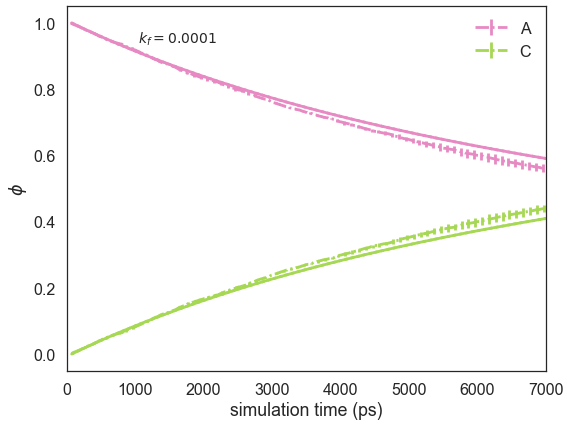

In [63]:
cr = '0.0001'
tD = avg_states_no_water[cr]['D']
tA = avg_states_no_water[cr]['A']
tC = avg_states_no_water[cr]['C']
tE = avg_states_no_water[cr]['E']

def f_de(y, t, k):
    cD   = y[0]
    cEs1 = y[1]
    cEs0 = y[2]
    kcD   = k
    kcEs1 = k
    kcEs0 = k
    
    dcDdt = -kcD*cD
    dcEs1dt = kcD*cD - kcEs1*cEs1
    dcEs0dt = kcEs1*cEs1
    
    return np.array([dcDdt, dcEs1dt, dcEs0dt])

t0 = np.linspace(73, tE[:, 0][-1], 100)

y0 = np.array([1.0, 0.0, 0.0])
y = odeint(f_de, y0, t0, args=(float(cr),))

def f_ac(y, t, k):
    a = y[0]
    c = y[1]
    dadt = -k*a**2
    dcdt = k*a**2
    
    return np.array([dadt, dcdt])

t0 = np.linspace(73, tE[:, 0][-1], 100)
y_ac = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(float(cr),))
y_ac_raw = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(float(cr),))

plt.rcParams['figure.figsize'] = (8, 6)
f, (a0) = plt.subplots(1,1) #, gridspec_kw = {'height_ratios':[2, 1]})

a0.errorbar(tA[:, 0], tA[:, 2]/2000.0, std_states_no_water[cr]['A'][:, 2]/2000.0, errorevery=100, 
             linestyle='-.', label='A', color=sns.color_palette('Set2', 6)[3])
a0.errorbar(tC[:, 0], tC[:, 1]/2000.0, std_states_no_water[cr]['C'][:, 1]/2000.0, errorevery=100, 
             linestyle='-.', label='C', color=sns.color_palette('Set2', 6)[4])
a0.plot(t0, y_ac[:, 0], color=sns.color_palette('Set2', 6)[3])
a0.plot(t0, y_ac[:, 1], color=sns.color_palette('Set2', 6)[4])
a0.plot(t0, y_ac_raw[:, 0], color=sns.color_palette('Set2', 6)[3], linestyle=':')
a0.plot(t0, y_ac_raw[:, 1], color=sns.color_palette('Set2', 6)[4], linestyle=':')
a0.annotate(r'$k_f={}$'.format(cr), xy=(0.15, 0.9), xycoords='axes fraction', fontsize=14)

a0.set_ylabel(r'$\phi$')
a0.set_xlim([0, 7000])
a0.legend(loc=0)
a0.set_xlabel('simulation time (ps)')


# fA = interp1d(tA[:, 0], tA[:, 2]/2000.0)
# fC = interp1d(tC[:, 0], tC[:, 1]/2000.0)
# a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac[:, 0], 2)), color='b')
# a1.plot(t0, np.sqrt(np.power(fC(t0) - y_ac[:, 1], 2)), color='b')
# a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac_raw[:, 0], 2)), color='r')
# a1.plot(t0, np.sqrt(np.power(fC(t0) - y_ac_raw[:, 1], 2)), color='r')
#a1.annotate(r'$k_c=1.0$', xy=(5000, 0.045), fontsize=12, color='r')
#a1.annotate(r'$k_c=1.4$', xy=(1500, 0.06), fontsize=12, color='b')

# a1.legend(loc=0)
# a1.set_xlim([0, 7000])
# a1.set_ylabel('RMSE')
# a0.set_xlabel('simulation time (ps)')

f.tight_layout()
f.savefig('conversions_no_water{}.pdf'.format(str(cr).replace('.', '_')), dpi=200)
#f.savefig('conversions_no_water{}.png'.format(str(cr).replace('.', '_')), dpi=200)

In [69]:
states_no_water66 = collections.defaultdict(dict)
nb_no_water66 = collections.defaultdict(dict)
t2name = {'t0': 'D', 't1': 'A', 't3': 'C', 't4': 'E', 't5': 'W'}
path = 'scan_p_1000/no_water_0.66/'
for f in os.listdir(path):
    if f.startswith('states_'):
        p = f.split('_')[3]
        type_id = f.split('_')[1]
        if type_id not in t2name:
            continue
        t = t2name[type_id]
        d = np.loadtxt(os.path.join(path, f))
        #d.dtype = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]
        if t not in states_no_water66[p]:
            states_no_water66[p][t] = []
        states_no_water66[p][t].append(d)
    elif f.startswith('nb_'):
        p = f.split('_')[6]
        t = f.split('_')[4]
        nb_no_water66[p][t] = np.loadtxt(os.path.join(path, f))
        #nb_no_water[p][t].dtype = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]

In [70]:
avg_states_no_water66 = collections.defaultdict(dict)
std_states_no_water66 = collections.defaultdict(dict)

max_states = {'A': 3, 'C': 3, 'E': 3, 'D': 3}
column = {'D': 3, 'A': 2, 'C': 1, 'E': 2}

for p, p_ts in states_no_water66.items():
    for t, l in p_ts.items():
        max_length = min([len(k) for k in l])
        max_first_nonzero = 0
        tmp_l = []
        for ll in l:
            dll = np.diff(ll[:, column[t]])
            first_nonzero = np.nonzero(dll)[0][0]
            if first_nonzero > max_first_nonzero:
                max_first_nonzero = first_nonzero
        for ll in l:
            tmp_l.append(ll[first_nonzero:max_length])
        av = np.average(tmp_l, axis=0)
        avg_states_no_water66[p][t] = av
        std_states_no_water66[p][t] = np.std(tmp_l, axis=0)

In [71]:
avg_states_no_water66.keys()

['0.0001', '0.01', '0.001']

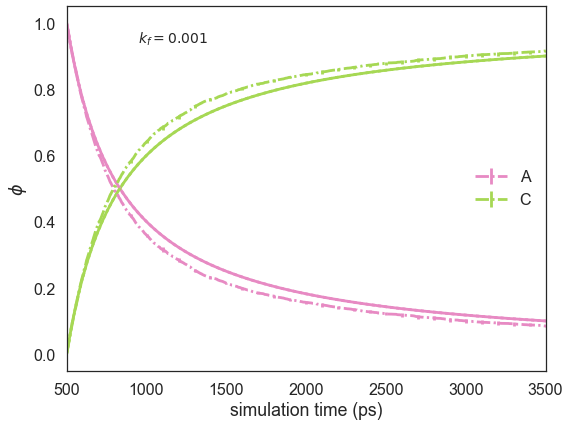

In [79]:
cr = '0.001'
tD = avg_states_no_water66[cr]['D']
tA = avg_states_no_water66[cr]['A']
tC = avg_states_no_water66[cr]['C']
tE = avg_states_no_water66[cr]['E']

min_step = 500

def f_de(y, t, k):
    cD   = y[0]
    cEs1 = y[1]
    cEs0 = y[2]
    kcD   = k
    kcEs1 = k
    kcEs0 = k
    
    dcDdt = -kcD*cD
    dcEs1dt = kcD*cD - kcEs1*cEs1
    dcEs0dt = kcEs1*cEs1
    
    return np.array([dcDdt, dcEs1dt, dcEs0dt])

t0 = np.linspace(min_step, tE[:, 0][-1], 100)

y0 = np.array([1.0, 0.0, 0.0])
y = odeint(f_de, y0, t0, args=(float(cr),))

def f_ac(y, t, k):
    a = y[0]
    c = y[1]
    dadt = -k*a**2
    dcdt = k*a**2
    
    return np.array([dadt, dcdt])

t0 = np.linspace(min_step, tE[:, 0][-1], 100)
y_ac = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(3.0*float(cr),))
y_ac_raw = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(3.0*float(cr),))

plt.rcParams['figure.figsize'] = (8, 6)
f, (a0) = plt.subplots(1,1) #, gridspec_kw = {'height_ratios':[2, 1]})

a0.errorbar(tA[:, 0], tA[:, 2]/2000.0, std_states_no_water66[cr]['A'][:, 2]/2000.0, errorevery=100, 
             linestyle='-.', label='A', color=sns.color_palette('Set2', 6)[3])
a0.errorbar(tC[:, 0], tC[:, 1]/2000.0, std_states_no_water66[cr]['C'][:, 1]/2000.0, errorevery=100, 
             linestyle='-.', label='C', color=sns.color_palette('Set2', 6)[4])
a0.plot(t0, y_ac[:, 0], color=sns.color_palette('Set2', 6)[3])
a0.plot(t0, y_ac[:, 1], color=sns.color_palette('Set2', 6)[4])
a0.plot(t0, y_ac_raw[:, 0], color=sns.color_palette('Set2', 6)[3], linestyle=':')
a0.plot(t0, y_ac_raw[:, 1], color=sns.color_palette('Set2', 6)[4], linestyle=':')
a0.annotate(r'$k_f={}$'.format(cr), xy=(0.15, 0.9), xycoords='axes fraction', fontsize=14)

a0.set_ylabel(r'$\phi$')
a0.set_xlim([500, 3500])
a0.legend(loc=0)
a0.set_xlabel('simulation time (ps)')


# fA = interp1d(tA[:, 0], tA[:, 2]/2000.0)
# fC = interp1d(tC[:, 0], tC[:, 1]/2000.0)
# a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac[:, 0], 2)), color='b')
# a1.plot(t0, np.sqrt(np.power(fC(t0) - y_ac[:, 1], 2)), color='b')
# a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac_raw[:, 0], 2)), color='r')
# a1.plot(t0, np.sqrt(np.power(fC(t0) - y_ac_raw[:, 1], 2)), color='r')
#a1.annotate(r'$k_c=1.0$', xy=(5000, 0.045), fontsize=12, color='r')
#a1.annotate(r'$k_c=1.4$', xy=(1500, 0.06), fontsize=12, color='b')

# a1.legend(loc=0)
# a1.set_xlim([0, 7000])
# a1.set_ylabel('RMSE')
# a0.set_xlabel('simulation time (ps)')

f.tight_layout()
#f.savefig('conversions_no_water{}.pdf'.format(str(cr).replace('.', '_')), dpi=200)
#f.savefig('conversions_no_water{}.png'.format(str(cr).replace('.', '_')), dpi=200)